In [159]:
import os
import numpy as np
import trimesh
import pyrender
import h5py
from mesh_to_png import mesh_to_png
from landmarks import detect_landmark
from data_def import PCAModel, Mesh
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
from torch.autograd import Variable
from collections import namedtuple

In [160]:
# Load Data
bfm = h5py.File("model2017-1_face12_nomouth.h5", 'r')
mean_tex = np.asarray(bfm['color/model/mean'], dtype=np.float32).reshape((-1, 3))
triangles = np.asarray(bfm['shape/representer/cells'], dtype=np.int32).T
# PCA model for facial identity
mu_id = np.asarray(bfm['shape/model/mean'], dtype=np.float32).reshape((-1, 3))
pcaBasis_id = np.asarray(bfm['shape/model/pcaBasis'], dtype=np.float32)
pcaVariance_id = np.asarray(bfm['shape/model/pcaVariance'], dtype=np.float32)
# PCA model for expression
mu_exp = np.asarray(bfm['expression/model/mean'], dtype=np.float32).reshape((-1, 3))
pcaBasis_exp = np.asarray(bfm['expression/model/pcaBasis'], dtype=np.float32)
pcaVariance_exp = np.asarray(bfm['expression/model/pcaVariance'], dtype=np.float32)
E_id = pcaBasis_id[:,:30].reshape((-1,3,30))
E_exp = pcaBasis_exp[:,:20].reshape((-1,3,20))
sigma_id = np.sqrt(pcaVariance_id[:30])
sigma_exp = np.sqrt(pcaVariance_exp[:20])

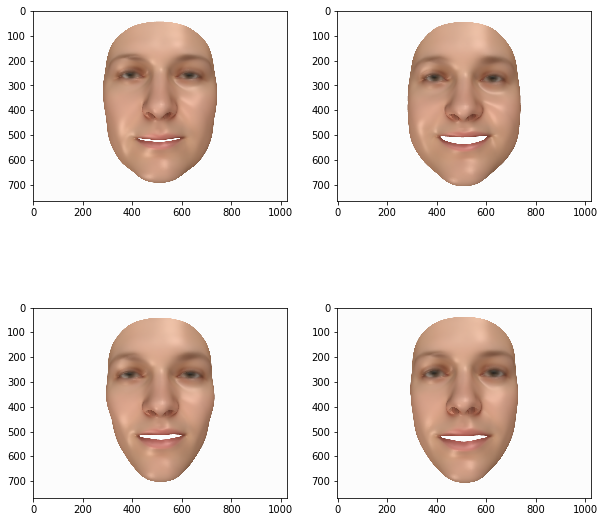

In [161]:
# Section 2 Morphable Model
# Generate point clouds using uniform sample
os.makedirs('results/',exist_ok=True)
fig1 = plt.figure(figsize = (10,10))
for i in range(4):
    alpha = np.random.uniform(-1,1,30)
    delta = np.random.uniform(-1,1,20)
    G = mu_id + E_id @ (alpha*sigma_id)  + mu_exp + E_exp @ (delta*sigma_exp)
    mesh = Mesh(G, mean_tex, triangles)
    filepath = 'results/point_cloud_sample{}.png'.format(i+1)
    mesh_to_png(filepath, mesh) 
    image = mpimg.imread(filepath)
    subplot = fig1.add_subplot(2,2,i+1)
    subplot.imshow(image)
plt.show()

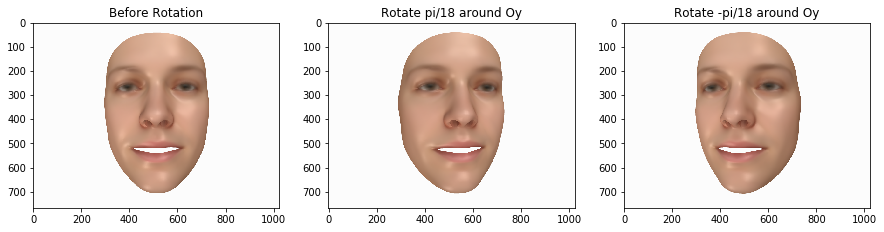

In [162]:
# Section 3 Pinhole camera model 
# Rotate around Oy
fig2 = plt.figure(figsize = (15,10))
subplot = fig2.add_subplot(1,3,1)
subplot.imshow(image)
subplot.set_title("Before Rotation")
# Rotate pi/18 around Oy 
theta = np.pi/18. 
R_y = np.array([[np.cos(theta),0, np.sin(theta)], [0,1,0],[-np.sin(theta),0,np.cos(theta)]])
G_t1 = (R_y @ G.T).T
mesh = Mesh(G_t1, mean_tex, triangles)
filepath = 'results/rotate_y1.png'
mesh_to_png(filepath, mesh) 
image_t = mpimg.imread(filepath)
subplot = fig2.add_subplot(1,3,2)
subplot.imshow(image_t)
subplot.set_title("Rotate pi/18 around Oy")
# Rotate -pi/18 around Oy
theta = -np.pi/18. 
R_y = np.array([[np.cos(theta),0, np.sin(theta)], [0,1,0],[-np.sin(theta),0,np.cos(theta)]])
G_t1 = (R_y @ G.T).T
mesh = Mesh(G_t1, mean_tex, triangles)
filepath = 'results/rotate_y2.png'
mesh_to_png(filepath, mesh) 
image_t = mpimg.imread(filepath)
subplot = fig2.add_subplot(1,3,3)
subplot.imshow(image_t)
subplot.set_title("Rotate -pi/18 around Oy")
plt.show()

/Users/robbie/anaconda3/envs/cv/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


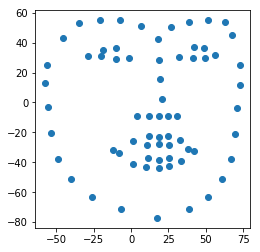

In [163]:
# visualize facial landmark points on the 2D image plane
landmark_index=[]
with open('Landmarks68_model2017-1_face12_nomouth.anl','r') as f:
    for line in f.readlines():
        landmark_index.append(int(line.split('\n')[0]))
G_landmark = np.ones((4,len(landmark_index)))
G_landmark[:3,:]= G[landmark_index,:].T
theta = np.pi/18.
T = np.array([[np.cos(theta),0, np.sin(theta),0],
              [0,1,0,0],[-np.sin(theta),0,np.cos(theta),0],
              [0,0,0,1]])
vl,vr,vb,vt = 0,1,0,1
V = np.array([[(vr-vl)/2.,0,0,(vr+vl)/2.],
              [0,(vt-vb)/2.,0,(vt+vb)/2.],
              [0,0,0.5,0.5],
              [0,0,0,1]])
l,r,b,t,n,f = 0,1,0,1,1,100
P = np.array([[(2*n)/(r-l),0,(r+l)/(r-l),0],
              [0,(2*n)/(t-b),(t+b)/(t-b),0],
              [0,0,-(f+n)/(f-n),-(2*f*n)/(f-b)],
              [0,0,-1,0]])
output = V @ P @ T @ G_landmark
plt.scatter(output[0,:],output[1,:])
plt.axes().set_aspect('equal')
plt.show()

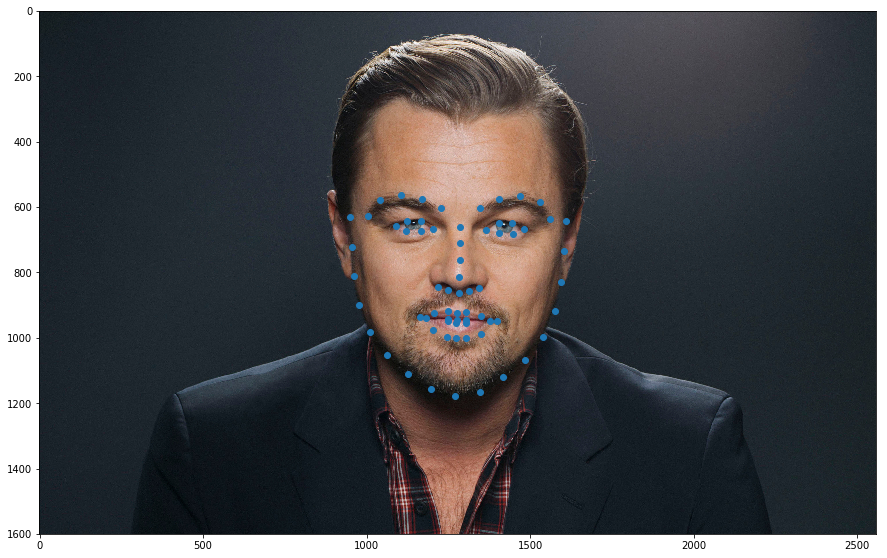

In [164]:
# Section 4
face_image = mpimg.imread('leo.jpg')
# face_image = (doge_image[:, :, :3] * 256).astype(np.uint8)
face_landmarks_gt = detect_landmark(face_image)
H, W = face_image.shape[0], face_image.shape[1]

fig = plt.figure(figsize = (15,10))
plt.imshow(face_image)
plt.scatter(face_landmarks_gt[:, 0], face_landmarks_gt[:, 1])
plt.axes().set_aspect('equal')
plt.show()
fig.savefig('results/face_landmarks_gt.png')

In [165]:
def get_transformation(omega,t):
    # Define Rotation matrix.
    Rx, Ry, Rz = torch.zeros(3, 3), torch.zeros(3, 3), torch.zeros(3, 3)
    Rx[0, 0] = 1.
    Rx[1, 1] = torch.cos(omega[0])
    Rx[1, 2] = -torch.sin(omega[0])
    Rx[2, 1] = torch.sin(omega[0])
    Rx[2, 2] = torch.cos(omega[0])

    Ry[0, 0] = torch.cos(omega[1])
    Ry[0, 2] = torch.sin(omega[1])
    Ry[1, 1] = 1.
    Ry[2, 0] = -torch.sin(omega[1])
    Ry[2, 2] = torch.cos(omega[1])
    
    Rz[0, 0] = torch.cos(omega[2])
    Rz[0, 1] = -torch.sin(omega[2])
    Rz[1, 0] = torch.sin(omega[2])
    Rz[1, 1] = torch.cos(omega[2])
    Rz[2, 2] = 1.
    
    R = Rx @ Ry @ Rz    
    T = torch.cat((torch.cat((R, t.view(-1, 1)), dim=1), torch.tensor([0., 0., 0., 1.]).view(1, -1)), dim=0)   
    return T

def get_projection(W, H, f, n, fovy):
    # Define camera projection matrices.
    V = torch.Tensor([[W/2, 0, 0, W/2],
                      [0, -H/2, 0, H/2],
                      [0, 0, 0.5, 0.5],
                      [0, 0, 0, 1]
                     ])

    aspect_ratio = W / H
    t = np.tan(fovy / 2) * n
    b = -t
    r = t * aspect_ratio
    l = -t * aspect_ratio
    P = torch.Tensor([[(2*n)/(r-l),0,(r+l)/(r-l),0],
                  [0,(2*n)/(t-b),(t+b)/(t-b),0],
                  [0,0,-(f+n)/(f-n),-(2*f*n)/(f-n)],
                  [0,0,-1,0]])
    return V, P

In [168]:
# Define Hyperparameters.
epochs = 500
lambda_alpha,lambda_delta= 1,1
fovy,near,far =0.5,300., 2000.

# Convert data to PyTorch tensors.
mu_id_torch = torch.Tensor(mu_id[landmark_index,:])
mu_exp_torch = torch.Tensor(mu_exp[landmark_index,:])
E_id_torch = torch.Tensor(E_id[landmark_index,:,:])
E_exp_torch = torch.Tensor(E_exp[landmark_index,:,:])
sigma_id_torch = torch.Tensor(sigma_id)
sigma_exp_torch = torch.Tensor(sigma_exp)

# Initialize trainable variables.
alpha_torch = Variable(torch.FloatTensor(30).uniform_(-1, 1), requires_grad=True)
delta_torch = Variable(torch.FloatTensor(20).uniform_(-1, 1), requires_grad=True)
omega = Variable(torch.zeros(3), requires_grad=True)
t = Variable(torch.Tensor([0, 0, -400]), requires_grad=True)

# Initialize optimizer.
opt = torch.optim.Adam([alpha_torch, alpha_torch, omega, t], lr=0.1)

# Define camera projection matrices.
V, P = Projection(W, H, far, near, fovy)
losses_land = []
losses_reg = []
losses_fit = []
for epoch in np.arange(epochs):
        opt.zero_grad()    
        G = mu_id_torch + E_id_torch @ (alpha_torch  * sigma_id_torch) + mu_exp_torch + E_exp_torch @ (delta_torch * sigma_exp_torch)    
        G_landmark = torch.cat((torch.transpose(G,0,1), torch.ones(1, len(landmarks))), 0)

        # Get Transformation
        T = get_transformation(omega,t)

        out = V @ P @ T @ G_landmark
        pred_landmark = out[:2, :] / out[3, :]

        L_landmark = (pred_landmark - gt_landmark).pow(2).sum(dim=0).sqrt().sum()
        L_regularizer = lambda_alpha * alpha_torch.pow(2).sum() + lambda_delta * delta_torch.pow(2).sum()
        L_fit = L_landmark + L_regularizer
        L_fit.backward(retain_graph=True)
        opt.step()    
        losses_land.append(L_landmark.item())
        losses_reg.append(L_regularizer)
        losses_fit.append(L_fit.item())
        if epoch % 10 ==0:
            print('Epoch: {}, L_landmark: {:.4f}, L_regularizer: {:.4f}, L_fit:{:.4f}'.format(epoch, L_landmark, L_regularizer,L_fit))    

Epoch: 0, L_landmark: 17990.2461, L_regularizer: 13.8749, L_fit:18004.1211
Epoch: 10, L_landmark: 12768.5566, L_regularizer: 84.7711, L_fit:12853.3281
Epoch: 20, L_landmark: 8055.5601, L_regularizer: 240.3532, L_fit:8295.9131
Epoch: 30, L_landmark: 4949.3828, L_regularizer: 408.9764, L_fit:5358.3594
Epoch: 40, L_landmark: 3017.8071, L_regularizer: 529.5572, L_fit:3547.3643
Epoch: 50, L_landmark: 2000.3352, L_regularizer: 564.4763, L_fit:2564.8115
Epoch: 60, L_landmark: 1416.7949, L_regularizer: 552.2858, L_fit:1969.0808
Epoch: 70, L_landmark: 1318.3741, L_regularizer: 513.9206, L_fit:1832.2947
Epoch: 80, L_landmark: 1153.3029, L_regularizer: 472.5364, L_fit:1625.8392
Epoch: 90, L_landmark: 1155.7435, L_regularizer: 443.7838, L_fit:1599.5273
Epoch: 100, L_landmark: 1061.2662, L_regularizer: 420.3735, L_fit:1481.6396
Epoch: 110, L_landmark: 1059.3057, L_regularizer: 400.6418, L_fit:1459.9475
Epoch: 120, L_landmark: 1015.2796, L_regularizer: 379.6174, L_fit:1394.8970
Epoch: 130, L_landmar

In [ ]:
fig = plt.figure(figsize= (15, 10))
plt.subplot(3, 1, 1)
plt.plot(np.arange(epochs), losses_fit)
plt.xlabel('Epochs')
plt.ylabel('L-fit')
plt.subplot(3, 1, 2)
plt.plot(np.arange(epochs), losses_land)
plt.xlabel('Epochs')
plt.ylabel('L-landmark')
plt.subplot(3, 1, 3)
plt.plot(np.arange(epochs), losses_reg)
plt.xlabel('Epochs')
plt.ylabel('L-reg')
plt.show()
fig.savefig('results/losses_uniform_{}.png'.format(str(uni).replace('.', '_')))

In [ ]:
fig = plt.figure(figsize = (15,10))
plt.imshow(face_image)
plt.scatter(face_landmarks_gt[:, 0], face_landmarks_gt[:, 1])
plt.scatter(pred_landmarks.numpy()[0, :] / pred_landmarks.numpy()[3, :], pred_landmarks.numpy()[1, :] / pred_landmarks.numpy()[3, :])
plt.axes().set_aspect('equal')
plt.show()
fig.savefig('results/landmarks_matches_uniform_{}.png'.format(str(uni).replace('.', '_')))

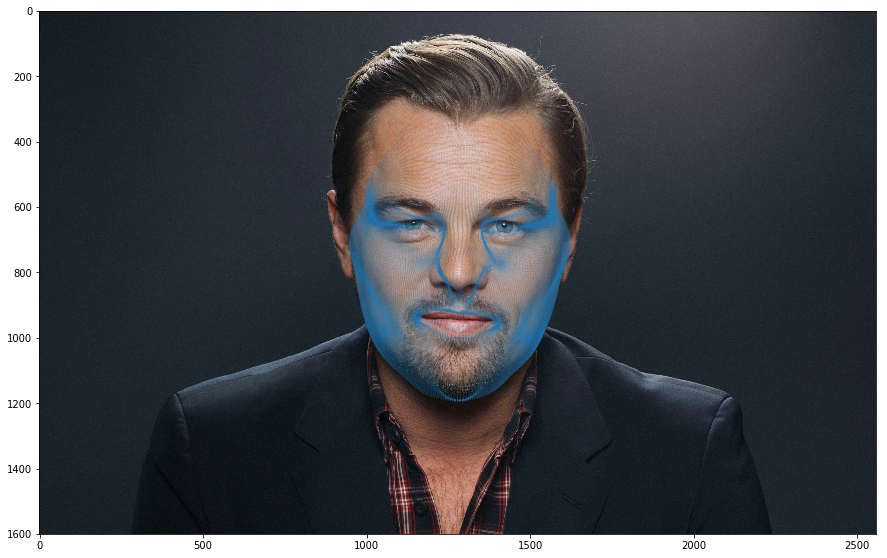

In [169]:
# Evaluatation
mu_id_eval = torch.Tensor(mu_id)
mu_exp_eval = torch.Tensor(mu_exp)
E_id_eval = torch.Tensor(E_id)
E_exp_eval = torch.Tensor(E_exp)
G = mu_id_eval + E_id_eval @ (alpha_torch * sigma_id_torch) + mu_exp_eval + E_exp_eval @ (delta_torch * sigma_exp_torch)  
G_homo = torch.cat((torch.transpose(G,0,1), torch.ones(1, G.size(0))), 0)
fit = V @ P @ T @ G_homo
fig = plt.figure(figsize=(15, 10))
plt.imshow(face_image)
ax=fig.add_subplot(111)
[x,y,z]=fit.detach().numpy()[:3, :] / fit.detach().numpy()[3, :]
ax.scatter(x,y,z,marker='.')
plt.show()
fig.savefig('results/point_cloud_fit_uniform_{}.png'.format(str(uni).replace('.', '_')))


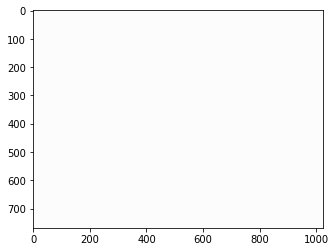

In [176]:
# Section 5
transformed = fit.detach().numpy()[:3, :] / fit.detach().numpy()[3, :]
interpolated = np.empty_like(transformed, dtype=np.uint8)
for p_i in np.arange(transformed.shape[1]):
    y = transformed[0, p_i]
    x = transformed[1, p_i]
    y1 = int(np.ceil(y)) % H
    y2 = int(np.floor(y)) % H 
    x1 = int(np.floor(x)) % W
    x2 = int(np.ceil(x)) % W   
#     print('y: {}, y1: {}, y2: {}'.format(y, y1, y2))
#     print('x: {}, x1: {}, x2: {}'.format(x, x1, x2))
    Q11 = face_image[y1, x1, :]
    Q12 = face_image[y2, x1, :]
    Q21 = face_image[y1, x1, :]
    Q22 = face_image[y2, x2, :]
    denom = ((x2 - x1) * (y2 - y1))
    if np.isclose(denom, 0.):
        interpolated[:, p_i] = np.array([128, 128, 128])
        continue
    for i_c in np.arange(3):                
        tmp = 1./denom * np.array([x2 - x, x - x1]) @ np.array([[Q11[i_c], Q12[i_c]], [Q21[i_c], Q22[i_c]]]) @ np.array([y2 - y, y - y1])        
        interpolated[i_c, p_i] = tmp
    texture = interpolated.T/255.

mesh = Mesh(transformed.T, mean_tex , triangles)
filepath = 'results/texturing.png'
mesh_to_png(filepath, mesh) 
image = mpimg.imread(filepath)
plt.imshow(image)


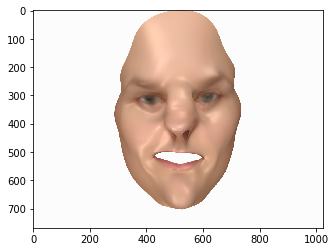

In [170]:
alpha = alpha_torch.detach().numpy()
delta = delta_torch.detach().numpy()
G = mu_id + E_id @ (alpha*sigma_id)  + mu_exp + E_exp @ (delta*sigma_exp)
filepath = 'results/texturing.png'
mesh = Mesh(G, mean_tex , triangles)
mesh_to_png(filepath, mesh) 
image = mpimg.imread(filepath)
plt.imshow(image)

In [ ]:
# Section 6
